# CFPB Text Classification Baselines
11/18/2022

Text classification on the Consumer Financial Protection Bureau (CFPB) Consumer Financial Complaints Database.

* andescon2022_cfpb_classify_baselines.ipynb
* andescon2022_cfpb_classify_transformer.ipynb

## IEEE ANDESCON 2022

IEEE Andean Conference: Technology and innovation, Barranquilla-Colombia, September 16-19, 2022

* https://nelscorrea.github.io/andescon2022



In [1]:
import numpy as np
import pandas as pd
import sklearn as sk
import tensorflow as tf

import copy, os, re, sys
from datetime import datetime
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

print(f"Versions - NumPy {np.__version__}, pandas {pd.__version__}, sklearn {sk.__version__}")
print(f"Versions - TensorFlow: {tf.__version__},\t Keras: {tf.keras.__version__}")

Versions - NumPy 1.22.4, pandas 1.4.3, sklearn 1.1.1
Versions - TensorFlow: 2.9.1,	 Keras: 2.9.0


# <a id="toc">Contents</a>

* [CFPB Consumer Financial Complaints Dataset - EDA](#eda)
* [TF-IDF Vectorizing](#tf-idf-vectorizing)
* [CFPB Dataset split](#dataset-split)
* [MNB Model: Multinomial Naive Bayes Classifier](#model-mnb)
* [MLP Model: Multilayer Perceptron Classifier](#model-mlp)
* [LSTM Model: Long Short Term Memory Model](#model-lstm)
* [Summary Performance](#summary-performance)



In [2]:
# Get CFPB data
remote_data_uri = "https://github.com/nelscorrea/datasets/raw/main/cfpb/consumer_complaints.csv.gz"
!pwd
!wget -Pdata $remote_data_uri
!gunzip -vfk ./data/consumer_complaints.csv.gz
!ls -la data

/Users/nelson/dev/nctalks/nlp/categorization/cfpb_20220612
--2022-12-16 02:29:45--  https://github.com/nelscorrea/datasets/raw/main/cfpb/consumer_complaints.csv.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nelscorrea/datasets/main/cfpb/consumer_complaints.csv.gz [following]
--2022-12-16 02:29:45--  https://raw.githubusercontent.com/nelscorrea/datasets/main/cfpb/consumer_complaints.csv.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8001::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37943046 (36M) [application/octet-stream]
Saving to: ‘data/consumer_complaints.csv.gz’

consumer_complaints 100%[===================>]  36.18

# <a id="eda">CFPB Consumer Financial Complaints Dataset - EDA</a>

* CFPB Consumer Financial Complaints Database
* CFPB URLs
* Kaggle

[top](#toc) 

In [3]:
%%time
# CSV or JSON files
cfpb_base = "./data/" # local data directory
cfpb_kaggle_csv_fn = "consumer_complaints.csv"

print(f"READ path: {cfpb_base}")
print(f"READING ... cfpb_json_fn: {cfpb_kaggle_csv_fn}")
ccd_df = pd.read_csv(cfpb_base+cfpb_kaggle_csv_fn)

print(f"ccd_df.shape: {ccd_df.shape}")
print(f"ccd_df.columns: {ccd_df.columns.to_list()}\n")
ccd_df.head(3)

READ path: ./data/
READING ... cfpb_json_fn: consumer_complaints.csv
ccd_df.shape: (555957, 18)
ccd_df.columns: ['date_received', 'product', 'sub_product', 'issue', 'sub_issue', 'consumer_complaint_narrative', 'company_public_response', 'company', 'state', 'zipcode', 'tags', 'consumer_consent_provided', 'submitted_via', 'date_sent_to_company', 'company_response_to_consumer', 'timely_response', 'consumer_disputed?', 'complaint_id']

CPU times: user 1.4 s, sys: 171 ms, total: 1.57 s
Wall time: 1.58 s


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
0,08/30/2013,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,U.S. Bancorp,CA,95993,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511074
1,08/30/2013,Mortgage,Other mortgage,"Loan servicing, payments, escrow account",NaN,NaN,NaN,Wells Fargo & Company,CA,91104,NaN,NaN,Referral,09/03/2013,Closed with explanation,Yes,Yes,511080
2,08/30/2013,Credit reporting,NaN,Incorrect information on credit report,Account status,NaN,NaN,Wells Fargo & Company,NY,11764,NaN,NaN,Postal mail,09/18/2013,Closed with explanation,Yes,No,510473


In [4]:
# CWH non-empty narrative
cwh_text = ccd_df['consumer_complaint_narrative'].notna()
cwh_notna = np.sum(cwh_text)
cwh_total = ccd_df.shape[0]
cwh_notnap = 100*cwh_notna/cwh_total
print("Complaints total: {0:,d}, non-empty narrative: {1:,d} ({2:.2f}%)".format(cwh_total, cwh_notna, cwh_notnap))

ccd_df = ccd_df[cwh_text]
print("CWH non-empty - ccd_df shape: {0}".format(ccd_df.shape))
ccd_df.tail(3)

Complaints total: 555,957, non-empty narrative: 66,806 (12.02%)
CWH non-empty - ccd_df shape: (66806, 18)


,date_received,product,sub_product,issue,sub_issue,consumer_complaint_narrative,company_public_response,company,state,zipcode,tags,consumer_consent_provided,submitted_via,date_sent_to_company,company_response_to_consumer,timely_response,consumer_disputed?,complaint_id
553086,02/11/2016,Payday loan,Payday loan,Charged fees or interest I didn't expect,Charged fees or interest I didn't expect,I have been paying {$180.00} a month through d...,NaN,Zarvad III S.A.,NV,891XX,Servicemember,Consent provided,Web,02/11/2016,Closed with explanation,Yes,No,1782804
553090,03/30/2016,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,I recently became aware that Amerisave Mortgag...,Company believes it acted appropriately as aut...,Amerisave,AZ,853XX,NaN,Consent provided,Web,03/30/2016,Closed with explanation,Yes,Yes,1855199
553096,02/12/2016,Mortgage,Conventional fixed mortgage,"Application, originator, mortgage broker",NaN,Bank of America has demonstrated an on-going l...,Company has responded to the consumer and the ...,Bank of America,GA,300XX,NaN,Consent provided,Web,02/12/2016,Closed with explanation,Yes,Yes,1786225


In [5]:
# Metadata for df: Char, Word counts
meta_columns = ["id", "Chars", "Words"]
m_meta_df = pd.DataFrame(columns=meta_columns)
m_meta_df[["Chars"]] = ccd_df[["consumer_complaint_narrative"]].applymap(len)
m_meta_df[["Words"]] = ccd_df[["consumer_complaint_narrative"]].applymap(lambda s: len(str.split(s)))
print("m_meta_df.shape: {0}".format(m_meta_df.shape))
m_meta_df.describe().T

m_meta_df.shape: (66806, 3)


,count,mean,std,min,25%,50%,75%,max
Chars,66806.0,1039.587327,910.270430,10.0,391.0,740.0,1383.0,5153.0
Words,66806.0,190.644014,166.830597,1.0,71.0,136.0,254.0,1284.0


Total complaints with narrative: 66,806


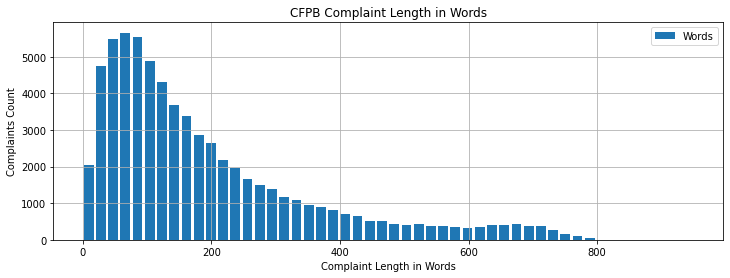

In [6]:
# Histogram: Chars, Words
print(f"Total complaints with narrative: {m_meta_df.shape[0]:,d}") # ({cwh_notnap:.2f}%)")
title = 'CFPB Complaint Length in Words'
xlabel = 'Complaint Length in Words'
ylabel = 'Complaints Count'

# ax = m_meta_df.hist(column=['Chars', 'Words'], bins=50, range=(0,950), rwidth=0.8,figsize=(12,4),grid=True)
ax = m_meta_df[['Words']].plot(kind="hist", bins=50, range=(0,950), title=title, rwidth=0.8,figsize=(12,4),grid=True)
_ = ax.set(xlabel=xlabel, ylabel=ylabel)

Total complaints with narrative: 66,806


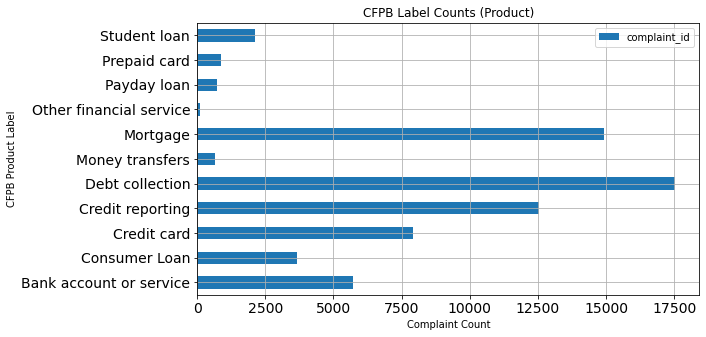

In [7]:
# Product histogram: Normalize to 100% total count
print(f"Total complaints with narrative: {ccd_df.shape[0]:,d}") # ({cwh_notnap:.2f}%)")
title = 'CFPB Label Counts (Product)'
xlabel = 'Complaint Count'
ylabel = 'CFPB Product Label'
# plt.title(title, fontsize=18)
ax = ccd_df.groupby(["product"]).count()[["complaint_id"]].plot(
    kind='barh', figsize=(9, 5), grid=True, title=title, ylabel=ylabel,  fontsize=14
)
_ = ax.set(xlabel=xlabel, ylabel=ylabel)

# <a id="tf-idf-vectorizing">TF-IDF Vectorizing</a>

Vectorizing full dataset (without split, with full vocabulary)

[top](#toc) 

In [8]:
%%time
# Sklearn
from sklearn.feature_extraction.text import CountVectorizer

texts = ccd_df["consumer_complaint_narrative"]
vectorizer = CountVectorizer()
vectorizer.fit(texts)

X_texts = vectorizer.transform(texts)
texts_vectorized_df = pd.DataFrame(X_texts[:].toarray(), columns=vectorizer.get_feature_names())
texts_wc = texts_vectorized_df.sum().sum()
vocabulary_size = len(vectorizer.get_feature_names())
print(f"Complaints - Vocabulary_size: {vocabulary_size:,d} \t Total words: {texts_wc:,d}\n")

Complaints - Vocabulary_size: 54,080 	 Total words: 11,851,488

CPU times: user 21.4 s, sys: 12.9 s, total: 34.3 s
Wall time: 37.6 s


In [9]:
# Sample Docs x Feats: texts_vectorized_df 
print(f"texts_vectorized_df.shape: {texts_vectorized_df.shape} \t Total words: {texts_wc:,d}")
texts_vectorized_df.head(3) # .sum() # .sum()

texts_vectorized_df.shape: (66806, 54080) 	 Total words: 11,851,488


,00,000,0000,00000,0001,000a,000dollars,000if,000ii,000ins,...,zombie,zone,zoned,zones,zoning,zoo,zoom,zooms,ztuff,zwicker
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# <a id="dataset-split">CFPB Dataset split</a>


In [10]:
# Dataset partition: train, dev, test
from sklearn.model_selection import train_test_split, cross_val_score

ccd_text = ccd_df['consumer_complaint_narrative']
ccd_label = ccd_df['product']
print(f"DATA - ccd_text: {len(ccd_text):,d} \t ccd_label: {len(ccd_label):,d}")

x_traindev, x_test, y_traindev, y_test = train_test_split(
    ccd_text, ccd_label, 
    random_state=287, shuffle=True, stratify=ccd_label,   # None,
    test_size=0.10
)

x_train, x_dev, y_train, y_dev = train_test_split(
    x_traindev, y_traindev, random_state=287, stratify=y_traindev, test_size=0.10
)

print(f"SIZE x_train: {len(x_train):,d} \t x_dev: {len(x_dev):,d} \t x_test: {len(x_test):,d}\n")

DATA - ccd_text: 66,806 	 ccd_label: 66,806
SIZE x_train: 54,112 	 x_dev: 6,013 	 x_test: 6,681



# <a id="model-mnb">MNB Model: Multinomial Naive Bayes Classifier</a>

* TfidfVectorizer: Train on x_train only
* 20,000 features 
* ngram = (1, 3)

[top](#toc) 

In [11]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB

# Model TfidfVectorizer
tokenizer = '(?u)\\b\\w\\w+\\b'
ngram = (1, 3)
max_features = 20000
vectorizer = sk.feature_extraction.text.TfidfVectorizer(
    token_pattern=tokenizer, ngram_range=ngram, max_features=max_features
)
vectorizer.fit(x_train)
print(f"Vectorizer features: {len(vectorizer.get_feature_names()):,d}, ngram size: {ngram}\n")

Vectorizer features: 20,000, ngram size: (1, 3)

CPU times: user 43.8 s, sys: 1.49 s, total: 45.3 s
Wall time: 45.4 s


In [12]:
# CCD Class label categories: WATCH order
max_label_char_size = 42

product_labels = [x[:max_label_char_size] for x in ccd_df.groupby(["product"]).count().index.to_list()]
product_labels

['Bank account or service',
 'Consumer Loan',
 'Credit card',
 'Credit reporting',
 'Debt collection',
 'Money transfers',
 'Mortgage',
 'Other financial service',
 'Payday loan',
 'Prepaid card',
 'Student loan']

In [13]:
%%time
# Multinomial Naive Bayes Model: MNB
model_name = "Multinomial-Naive-Bayes"
model_mnb = sk.pipeline.make_pipeline(vectorizer, sk.naive_bayes.MultinomialNB())
model_mnb.fit(x_train, y_train)

CPU times: user 45.2 s, sys: 1.52 s, total: 46.7 s
Wall time: 47 s


Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(max_features=20000, ngram_range=(1, 3))),
                ('multinomialnb', MultinomialNB())])

In [14]:
%%time
# MNB DEV/TEST/TRAIN score 
dev_score = model_mnb.score(x_dev, y_dev)
test_score = model_mnb.score(x_test, y_test)
# train_score = model_mnb.score(x_train, y_train)
print(f"{model_name}: Accuracy")
print(f"  DEV score: {100*dev_score:.2f}")
print(f" TEST score: {100*test_score:.2f}")
# print(f"TRAIN score: {100*train_score:.2f}\n")

Multinomial-Naive-Bayes: Accuracy
 DEV score: 78.55
TEST score: 77.74

CPU times: user 4.85 s, sys: 93 ms, total: 4.94 s
Wall time: 4.97 s


In [15]:
%%time
# Classification Report
y_test_predicted = model_mnb.predict(x_test)
print(f"{model_name}: TEST Classification Report")
print(sk.metrics.classification_report(y_test, y_test_predicted, target_names=product_labels))

Multinomial-Naive-Bayes: TEST Classification Report
                         precision    recall  f1-score   support

Bank account or service       0.74      0.79      0.76       571
          Consumer Loan       0.89      0.36      0.51       368
            Credit card       0.71      0.77      0.74       793
       Credit reporting       0.75      0.85      0.79      1253
        Debt collection       0.79      0.83      0.80      1755
        Money transfers       0.00      0.00      0.00        66
               Mortgage       0.82      0.94      0.88      1492
Other financial service       0.00      0.00      0.00        11
            Payday loan       0.00      0.00      0.00        73
           Prepaid card       1.00      0.02      0.05        86
           Student loan       0.93      0.45      0.61       213

               accuracy                           0.78      6681
              macro avg       0.60      0.45      0.47      6681
           weighted avg       0.77  

Multinomial-Naive-Bayes: TEST Confusion Matrix


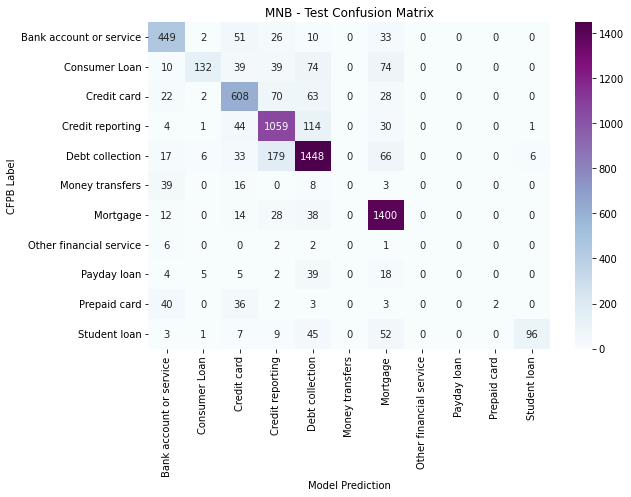

In [16]:
print(f"{model_name}: TEST Confusion Matrix")
product_mat = sk.metrics.confusion_matrix(y_test, y_test_predicted)

fig, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(product_mat, annot=True, fmt="d", cbar=True, cmap="BuPu", xticklabels=product_labels, yticklabels=product_labels)
plt.ylabel('CFPB Label')
plt.xlabel('Model Prediction')
plt.title('MNB - Test Confusion Matrix')
plt.show()

# <a id="model-mlp">MLP Model: Multilayer Perceptron Classifier</a>

* Binary Keras Tokenizer
* MLP model: input, hidden and output layers

Note: MLP uses a binary tokenizer. MNB model used a TF-IDF vectorizer with 20,000 features, ngram=(0,3)

[top](#toc) 

In [17]:
%%time
# Keras Tokenizer

# train/dev/test data to use
train_size = x_train.shape[0]
dev_size = x_dev.shape[0]   # 2000
test_size = x_test.shape[0] # 2000

max_features = 20000
print(f"TOK inputs - x_train: {len(x_train):,d}, x_dev: {len(x_dev):,d}, x_test: {len(x_test):,d}")

tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=max_features, oov_token='UNK')
tokenizer.fit_on_texts(x_train)  # Fit only on x_train
print(f"TOK - max_features: {tokenizer.num_words:,d}, word_index (vocabulary): {len(tokenizer.word_index):,d}")

X_train = tokenizer.texts_to_sequences(x_train[:train_size])
X_dev = tokenizer.texts_to_sequences(x_dev[:dev_size])
X_test = tokenizer.texts_to_sequences(x_test[:test_size])
print(f"X_train: {len(X_train):,d}, X_dev: {len(X_dev):,d}, X_test: {len(X_test):,d}\n")
# X_train[:2], X_dev[:2]

TOK inputs - x_train: 54,112, x_dev: 6,013, x_test: 6,681
TOK - max_features: 20,000, word_index (vocabulary): 49,264
X_train: 54,112, X_dev: 6,013, X_test: 6,681

CPU times: user 10.1 s, sys: 76.1 ms, total: 10.2 s
Wall time: 10.2 s


In [18]:
%%time
# Vectorize text into binary features
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

t0 = datetime.now()
x_train_b = vectorize_sequences(X_train[:train_size], max_features)
x_dev_b = vectorize_sequences(X_dev[:dev_size], max_features)
x_test_b = vectorize_sequences(X_test[:test_size], max_features)
t1 = datetime.now()
print(f"KERAS CFPB Complaints vectorize_sequences: {t1-t0}\n")

KERAS CFPB Complaints vectorize_sequences: 0:00:02.301487

CPU times: user 1.51 s, sys: 713 ms, total: 2.23 s
Wall time: 2.3 s


In [19]:
# vectorize labels
labencoder = sk.preprocessing.LabelEncoder()
y_train_int = labencoder.fit_transform(y_train[:train_size])
y_dev_int = labencoder.fit_transform(y_dev[:dev_size])
y_test_int = labencoder.transform(y_test[:test_size])

y_train_1h = tf.keras.utils.to_categorical(np.asarray(y_train_int))
y_dev_1h = tf.keras.utils.to_categorical(np.asarray(y_dev_int))
y_test_1h = tf.keras.utils.to_categorical(np.asarray(y_test_int))

print(f"Encoder Classes ({len(labencoder.classes_)}): {labencoder.classes_}\n")
print("Encoder Classes/Counts train:", np.unique(y_train_int, return_counts=True))
print("Encoder Classes/Counts dev:", np.unique(y_dev_int, return_counts=True))
print("Encoder Classes/Counts test:", np.unique(y_test_int, return_counts=True))

Encoder Classes (11): ['Bank account or service' 'Consumer Loan' 'Credit card'
 'Credit reporting' 'Debt collection' 'Money transfers' 'Mortgage'
 'Other financial service' 'Payday loan' 'Prepaid card' 'Student loan']

Encoder Classes/Counts train: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([ 4626,  2979,  6422, 10146, 14217,   540, 12084,    89,   588,
         698,  1723]))
Encoder Classes/Counts dev: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([ 514,  331,  714, 1127, 1580,   60, 1343,   10,   65,   77,  192]))
Encoder Classes/Counts test: (array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([ 571,  368,  793, 1253, 1755,   66, 1492,   11,   73,   86,  213]))


In [20]:
# MLP model
dense_nodes = 128    # Network: max_features x 128d x 128dp x 128d x 11o. Explore 64, 128
output_classes = 11   # Keras Reuters dataset classes
dropout = 0.5        # Explore 0.0, 0.2, 0.5

model_name = "Bin-BOW-MLP-128"
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(dense_nodes, activation='relu', input_shape=(max_features,)))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.Dense(dense_nodes, activation='relu'))
model.add(tf.keras.layers.Dropout(dropout))
model.add(tf.keras.layers.Dense(output_classes, activation='softmax'))

# MLP model compile & describe
print("max_features:", max_features)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

2022-12-16 02:35:17.051735: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


max_features: 20000
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2560128   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 11)                1419      
                                                                 
Total params: 2,578,059
Trainable params: 2,578,059
Non-trainable params: 0
_________________________________________________________________


In [21]:
%%time
# Train model
batch_size = 128 # 32, 64, 128, 512
epochs = 10

# Time
start_time = datetime.now()
print("Start CFPB MLP training:", str(start_time))

history = model.fit(x_train_b, y_train_1h,
                    epochs=epochs, batch_size=batch_size, 
                    validation_data=(x_dev_b, y_dev_1h))

# Time
end_time = datetime.now()
model_mlp = model
print(f"End train MLP: {str(end_time)}")
print(f"Time: {str(end_time-start_time)}\n")

Start CFPB MLP training: 2022-12-16 02:35:35.390936
Epoch 1/10
423/423 [==============================] - 14s 32ms/step - loss: 0.8760 - accuracy: 0.7416 - val_loss: 0.5826 - val_accuracy: 0.8305
Epoch 2/10
423/423 [==============================] - 9s 21ms/step - loss: 0.5651 - accuracy: 0.8384 - val_loss: 0.5305 - val_accuracy: 0.8528
Epoch 3/10
423/423 [==============================] - 9s 21ms/step - loss: 0.4858 - accuracy: 0.8605 - val_loss: 0.5324 - val_accuracy: 0.8580
Epoch 4/10
423/423 [==============================] - 9s 22ms/step - loss: 0.4423 - accuracy: 0.8751 - val_loss: 0.5300 - val_accuracy: 0.8576
Epoch 5/10
423/423 [==============================] - 9s 22ms/step - loss: 0.4065 - accuracy: 0.8839 - val_loss: 0.5416 - val_accuracy: 0.8588
Epoch 6/10
423/423 [==============================] - 9s 22ms/step - loss: 0.3755 - accuracy: 0.8934 - val_loss: 0.5559 - val_accuracy: 0.8563
Epoch 7/10
423/423 [==============================] - 10s 23ms/step - loss: 0.3525 - accu

In [22]:
%%time
# Evaluate: DEV/TEST/TRAIN accuracy
dev_loss, dev_acc = model.evaluate(x_dev_b, y_dev_1h)
test_loss, test_acc = model.evaluate(x_test_b, y_test_1h)
train_loss, train_acc = model.evaluate(x_train_b, y_train_1h)

print(f"\n{model_name}: Accuracy")
print(f"  DEV loss: {dev_loss:.2f}\t accuracy: {100*dev_acc:.2f}")
print(f" TEST loss: {test_loss:.2f}\t accuracy: {100*test_acc:.2f}")
print(f"TRAIN loss: {train_loss:.2f}\t accuracy: {100*train_acc:.2f}\n")

1691/1691 [==============================] - 7s 4ms/step - loss: 0.1634 - accuracy: 0.9523

BoW_MLP-128: Accuracy
  DEV loss: 0.65	 accuracy: 85.83
 TEST loss: 0.68	 accuracy: 85.26
TRAIN loss: 0.16	 accuracy: 95.23

CPU times: user 26.6 s, sys: 9.75 s, total: 36.4 s
Wall time: 18.1 s


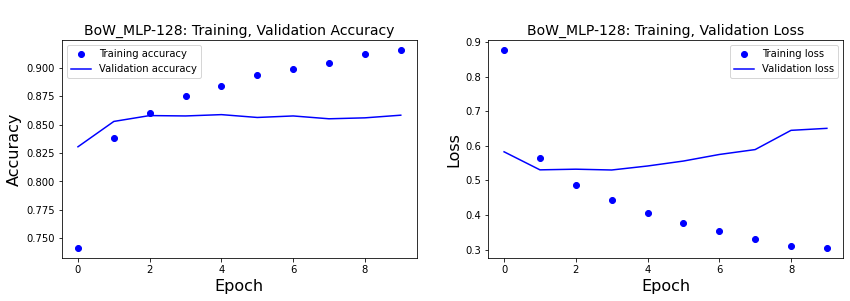

In [23]:
# Plot: MLP Embedding-20000 x 128 x 128dp x 128 x 11
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title(f'\n{model_name}: Training, Validation Accuracy', fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title(f'\n{model_name}: Training, Validation Loss', fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()

plt.show()

In [24]:
%%time
# Classification report on TEST data
y_test_predicted = model.predict(x_test_b).argmax(axis=1)
print(f"\n{model_name}: TEST Classification Report")
print(sk.metrics.classification_report(y_test_int, y_test_predicted, target_names=product_labels))

209/209 [==============================] - 1s 2ms/step

BoW_MLP-128: TEST Classification Report
                         precision    recall  f1-score   support

Bank account or service       0.82      0.78      0.80       571
          Consumer Loan       0.72      0.64      0.68       368
            Credit card       0.82      0.78      0.80       793
       Credit reporting       0.87      0.88      0.87      1253
        Debt collection       0.82      0.90      0.86      1755
        Money transfers       0.76      0.52      0.61        66
               Mortgage       0.94      0.95      0.94      1492
Other financial service       0.00      0.00      0.00        11
            Payday loan       0.67      0.44      0.53        73
           Prepaid card       0.81      0.72      0.76        86
           Student loan       0.92      0.79      0.85       213

               accuracy                           0.85      6681
              macro avg       0.74      0.67      0.70   

BoW_MLP-128: TEST Confusion Matrix


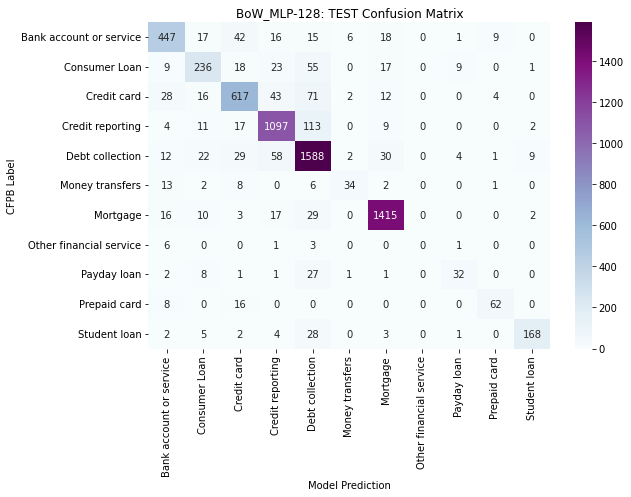

In [25]:
# Confusion matrix on TEST data
print(f"{model_name}: TEST Confusion Matrix")
product_mat = sk.metrics.confusion_matrix(y_test_int, y_test_predicted)

fig, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(product_mat, annot=True, fmt="d", cbar=True, cmap="BuPu", xticklabels=product_labels, yticklabels=product_labels)
plt.ylabel('CFPB Label')
plt.xlabel('Model Prediction')
plt.title(f"{model_name}: TEST Confusion Matrix")
plt.show()

# <a id="model-lstm">LSTM Model: Long Short Term Memory Model</a>

* input embedding layer 100, etc.

[top](#toc) 

In [26]:
# CFPB labels and input data splits
print(f"Data splits - X_train: {len(X_train):,d}, X_dev: {len(X_dev):,d}, X_test: {len(X_test):,d}")
print(f"Class labels ({len(product_labels)}): {product_labels}")

Data splits - X_train: 54,112, X_dev: 6,013, X_test: 6,681
Class labels (11): ['Bank account or service', 'Consumer Loan', 'Credit card', 'Credit reporting', 'Debt collection', 'Money transfers', 'Mortgage', 'Other financial service', 'Payday loan', 'Prepaid card', 'Student loan']


In [27]:
%%time
# Limit and pad input sequences to maxlen words
maxlen = 200 # Input length

# Fixed-length features, maxlen
x_train_fl = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=maxlen, truncating='post', padding='pre')
x_dev_fl = tf.keras.preprocessing.sequence.pad_sequences(X_dev, maxlen=maxlen, truncating='post', padding='pre')
x_test_fl = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=maxlen, truncating='post', padding='pre')

# Sample text input
print(f"Sample text x_train_len[0] (length = {len(x_train_fl[0])}):\n {x_train_fl[0]}\n")

Sample text x_train_len[0] (length = 200):
 [    0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     4    75   301
   409  3379    65   363    42  1930    10   333   820     5    18    66
    10 

In [28]:
# LSTM Model with trainable input embedding layer
embed_dim = 100  # Explore 32, 50, 100
lstm_size = 64   # Explore 32, 64, 128
dense_nodes = 128

dropout = 0.2    # Dropouts
input_dropout = 0.2; 
recurrent_dropout = 0.3

num_classes = len(product_labels)  # 11 CCD product classes

# Bi-directional LSTM of lstm_size=64 (128 LSTM nodes total)
model_name = "E100_Bi-LSTM-64"
model = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(max_features, embed_dim),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(lstm_size, dropout=input_dropout, recurrent_dropout=recurrent_dropout)
    ),
    tf.keras.layers.Dense(dense_nodes, activation='relu'),
    tf.keras.layers.Dropout(dropout),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
print(f"Model: {model_name}, max_features: {max_features}, embed_dim: {embed_dim}, output_classes: {num_classes}")
print(f"lstm_size: {lstm_size}, dropout: {dropout}, input_dropout: {input_dropout}, recurrent_dropout: {recurrent_dropout}\n")
model.summary()

Model: E100_Bi-LSTM-64, max_features: 20000, embed_dim: 100, output_classes: 11
lstm_size: 64, dropout: 0.2, input_dropout: 0.2, recurrent_dropout: 0.3

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         2000000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              84480     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 128)               16512     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 11)                1419      
                                 

In [29]:
%%time
# Train model
epochs = 12
batch_size = 64   # 32, 64, 128, 512
val_split = 0.1

# Time
start_time = datetime.now()
print(f"Start train LSTM: {str(start_time)}")
print(f"model_name: {model_name}, epochs: {epochs}, batch_size: {batch_size}, lstm_size: {lstm_size}")

history = model.fit(x_train_fl, y_train_1h,
                    epochs=epochs, batch_size=batch_size, 
                    # validation_split=val_split, 
                    validation_data=(x_dev_fl, y_dev_1h))

# Time
end_time = datetime.now()
model_lstm = model
print(f"End train LSTM: {str(end_time)}")
print(f"Time: {str(end_time-start_time)}\n")

Start train LSTM: 2022-12-16 02:40:40.476394
model_name: E100_Bi-LSTM-64, epochs: 12, batch_size: 64, lstm_size: 64
Epoch 1/12
846/846 [==============================] - 273s 312ms/step - loss: 1.2588 - accuracy: 0.5805 - val_loss: 0.9036 - val_accuracy: 0.7529
Epoch 2/12
846/846 [==============================] - 285s 336ms/step - loss: 0.8293 - accuracy: 0.7605 - val_loss: 0.8060 - val_accuracy: 0.7577
Epoch 3/12
846/846 [==============================] - 274s 324ms/step - loss: 0.7164 - accuracy: 0.7933 - val_loss: 0.7428 - val_accuracy: 0.7861
Epoch 4/12
846/846 [==============================] - 254s 301ms/step - loss: 0.6276 - accuracy: 0.8199 - val_loss: 0.6820 - val_accuracy: 0.8099
Epoch 5/12
846/846 [==============================] - 253s 299ms/step - loss: 0.5708 - accuracy: 0.8360 - val_loss: 0.6130 - val_accuracy: 0.8260
Epoch 6/12
846/846 [==============================] - 253s 299ms/step - loss: 0.5197 - accuracy: 0.8496 - val_loss: 0.5850 - val_accuracy: 0.8320
Epoch 7/

In [30]:
%%time
# Evaluate: DEV/TEST/TRAIN accuracy
dev_loss, dev_acc = model.evaluate(x_dev_fl, y_dev_1h)
test_loss, test_acc = model.evaluate(x_test_fl, y_test_1h)
train_loss, train_acc = model.evaluate(x_train_fl, y_train_1h)

print(f"\n{model_name}: Accuracy")
print(f"  DEV loss: {dev_loss:.2f}\t accuracy: {100*dev_acc:.2f}")
print(f" TEST loss: {test_loss:.2f}\t accuracy: {100*test_acc:.2f}")
print(f"TRAIN loss: {train_loss:.2f}\t accuracy: {100*train_acc:.2f}\n")

1691/1691 [==============================] - 54s 32ms/step - loss: 0.2903 - accuracy: 0.9124

E100_Bi-LSTM-64: Accuracy
  DEV loss: 0.55	 accuracy: 85.12
 TEST loss: 0.57	 accuracy: 84.94
TRAIN loss: 0.29	 accuracy: 91.24

CPU times: user 6min 23s, sys: 36.5 s, total: 7min
Wall time: 1min 4s


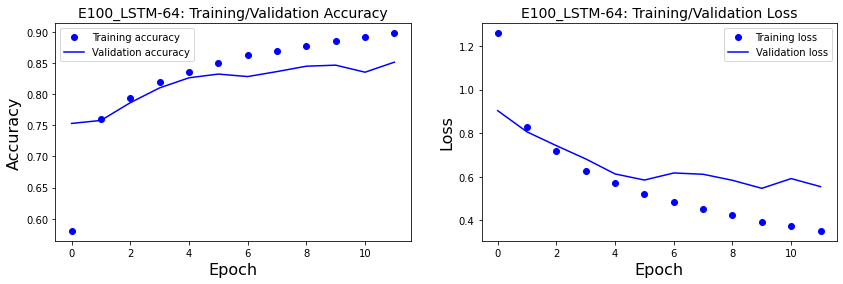

In [31]:
# E100_Bi-LSTM-64
model_name = "E100_LSTM-64"
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title(f"{model_name}: Training/Validation Accuracy", fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend()

plt.subplot(122)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title(f"{model_name}: Training/Validation Loss", fontsize=14)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend()

plt.show()

209/209 [==============================] - 5s 25ms/step
CPU times: user 58.8 s, sys: 6.18 s, total: 1min 5s
Wall time: 10.5 s


In [32]:
%%time
y_test_predicted = model.predict(x_test_fl).argmax(axis=1)
print(f"\n{model_name}: TEST Classification Report")
print(sk.metrics.classification_report(y_test_int, y_test_predicted, target_names=product_labels))

209/209 [==============================] - 6s 25ms/step

E100_LSTM-64: TEST Classification Report
                         precision    recall  f1-score   support

Bank account or service       0.78      0.78      0.78       571
          Consumer Loan       0.73      0.65      0.69       368
            Credit card       0.77      0.84      0.80       793
       Credit reporting       0.89      0.85      0.87      1253
        Debt collection       0.84      0.89      0.86      1755
        Money transfers       0.78      0.44      0.56        66
               Mortgage       0.93      0.94      0.94      1492
Other financial service       0.00      0.00      0.00        11
            Payday loan       0.62      0.29      0.39        73
           Prepaid card       0.88      0.67      0.76        86
           Student loan       0.87      0.85      0.86       213

               accuracy                           0.85      6681
              macro avg       0.74      0.65      0.68 


E100_LSTM-64: TEST Confusion Matrix


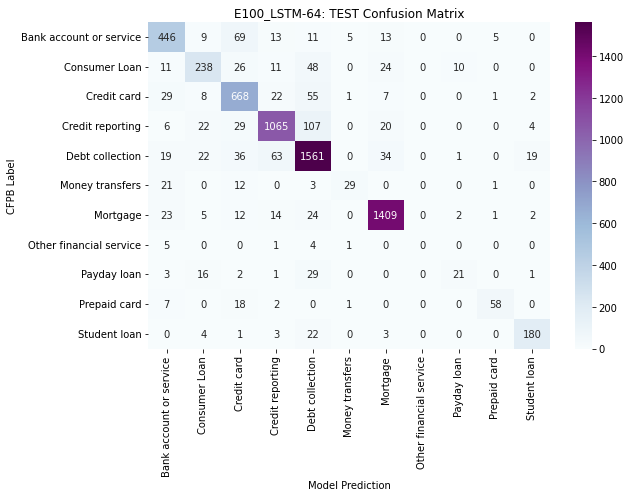

In [33]:
# Confusion matrix on TEST data
print(f"\n{model_name}: TEST Confusion Matrix")
product_mat = sk.metrics.confusion_matrix(y_test_int, y_test_predicted)

fig, ax = plt.subplots(figsize=(9, 6))
sns.heatmap(product_mat, annot=True, fmt="d", cbar=True, cmap="BuPu", xticklabels=product_labels, yticklabels=product_labels)
plt.ylabel('CFPB Label')
plt.xlabel('Model Prediction')
plt.title(f"{model_name}: TEST Confusion Matrix")
plt.show()

# <a id="summary-performance">Summary performance</a>

Baseline models performance: Accuracy

* model_mnb
* model_mlp
* model_lstm

[top](#toc) 

In [34]:
%%time
# MNB score 
model_name = "Multinomial-Naive-Bayes"
dev_score = model_mnb.score(x_dev, y_dev)
test_score = model_mnb.score(x_test, y_test)
print(f"{model_name}: Accuracy")
print(f" DEV score: {100*dev_score:.2f}")
print(f"TEST score: {100*test_score:.2f}\n")

Multinomial-Naive-Bayes: Accuracy
 DEV score: 78.55
TEST score: 77.74

CPU times: user 5.2 s, sys: 426 ms, total: 5.62 s
Wall time: 6.11 s


In [35]:
%%time
# MLP: DEV/TEST/TRAIN accuracy
dev_loss, dev_acc = model_mlp.evaluate(x_dev_b, y_dev_1h)
test_loss, test_acc = model_mlp.evaluate(x_test_b, y_test_1h)
train_loss, train_acc = model_mlp.evaluate(x_train_b, y_train_1h)

model_name = "BoW_MLP-128"
print(f"\n{model_name}: Accuracy")
print(f"  DEV loss: {dev_loss:.2f}\t accuracy: {100*dev_acc:.2f}")
print(f" TEST loss: {test_loss:.2f}\t accuracy: {100*test_acc:.2f}")
print(f"TRAIN loss: {train_loss:.2f}\t accuracy: {100*train_acc:.2f}\n")

1691/1691 [==============================] - 6s 3ms/step - loss: 0.1634 - accuracy: 0.9523

BoW_MLP-128: Accuracy
  DEV loss: 0.65	 accuracy: 85.83
 TEST loss: 0.68	 accuracy: 85.26
TRAIN loss: 0.16	 accuracy: 95.23

CPU times: user 24.5 s, sys: 9.63 s, total: 34.2 s
Wall time: 18.9 s


In [36]:
%%time
# LSTM: DEV/TEST/TRAIN accuracy
dev_loss, dev_acc = model_lstm.evaluate(x_dev_fl, y_dev_1h)
test_loss, test_acc = model_lstm.evaluate(x_test_fl, y_test_1h)
train_loss, train_acc = model_lstm.evaluate(x_train_fl, y_train_1h)

model_name = "E100_LSTM-64"
print(f"\n{model_name}: Accuracy")
print(f"  DEV loss: {dev_loss:.2f}\t accuracy: {100*dev_acc:.2f}")
print(f" TEST loss: {test_loss:.2f}\t accuracy: {100*test_acc:.2f}")
print(f"TRAIN loss: {train_loss:.2f}\t accuracy: {100*train_acc:.2f}\n")

1691/1691 [==============================] - 51s 30ms/step - loss: 0.2903 - accuracy: 0.9124

E100_LSTM-64: Accuracy
  DEV loss: 0.55	 accuracy: 85.12
 TEST loss: 0.57	 accuracy: 84.94
TRAIN loss: 0.29	 accuracy: 91.24

CPU times: user 6min 7s, sys: 36.2 s, total: 6min 44s
Wall time: 1min 2s


In [ ]:
# EOF